In [262]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import random
import time

In [263]:
dataFolder = "C:\\Users\\chris\\Documents\\GitHub\\open-data\\open-data\\data\\"
matchesFolder = dataFolder + "matches\\"
lineupsFolder = dataFolder + "lineups\\"
eventsFolder = dataFolder + "events\\"

In [264]:
def json_loads(filepath):
    with open(filepath, encoding="utf-8") as json_file:
        n = json.load(json_file)
    return n

In [265]:
def tts(timestamp):
    n = 0
    for i in range(3):
        n += float(timestamp.split(":")[i]) * (60 ** (2-i))
    return n

def ttm(timestamp):
    n = tts(timestamp) / 60
    return n

In [266]:
def per90(DataFrame, columns):
    mins = "minutes_played"
    if mins in DataFrame.columns:
        m = DataFrame[mins]
    else:
        m = DataFrame["minutes_max"]
    n = pd.DataFrame(index = DataFrame.index)
    for col in columns:
        n[col] = 90*DataFrame[col]/m
    return n

In [267]:
def graph(figdim):
    fig, ax = plt.subplots(figsize=figdim)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    return fig, ax, plt

In [268]:
def Rectangle(fig, ax, plt, start, end, colour):
    corners = [start, [start[0], end[1]], end, [end[0], start[1]], start]
    for r in range(4):
        plt.plot([corners[r][0], corners[r+1][0]], [corners[r][1], corners[r+1][1]], c = colour)
    return fig, ax, plt

In [269]:
def draw_pitch(colour="white", bg="seagreen"):
    fig, ax, plt = graph((12, 8))
    fig.patch.set_facecolor(bg)
    Rectangle(fig, ax, plt, [0, 0], [120, -80], colour)
    plt.plot([60, 60], [0, -80], c = colour)
    for i in range(2):
        j = [120*i, 80*i]
        Rectangle(fig, ax, plt, [abs(j[0] - 0), -abs(j[1] -18)], [abs(j[0] - 18), -abs(j[1]- 62)], colour)
        Rectangle(fig, ax, plt, [abs(j[0] - 0), -abs(j[1] - 30)], [abs(j[0] - 6), -abs(j[1] - 50)], colour)
    Rectangle(fig, ax, plt, [- 2, - 36], [ 0, - 44], colour)
    Rectangle(fig, ax, plt, [120, -44], [122, - 36], colour)

    centreCircle = plt.Circle((60,-40),8.1,color=colour, fill = False)
    centreSpot = plt.Circle((60,-40),0.4,color=colour)
    leftPenSpot = plt.Circle((12,-40),0.4,color=colour)
    rightPenSpot = plt.Circle((108,-40),0.4,color=colour)

    leftArc = Arc((13,-40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color=colour)
    rightArc = Arc((107,-40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color=colour)
    element = [centreCircle, centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)
    plt.axis('off')
    return fig, ax, plt

In [270]:
def titling(fig, ax, plt, c1, x, texty, deltay, t, h):
    for i in range(len(t)):
        if i == 0:
            w = "bold"
        else:
            w = "normal"
        plt.text(x, texty - i * deltay, t[i], ha=h, color=c1, fontsize=12, weight=w)
    return fig, ax, plt

In [271]:
def matchstep(matchDataFrame):
    DataFrame = matchDataFrame
    fig, ax, plt = graph((8, 6))
    plt.grid(True, axis="y", linestyle="-")

    plt.axhline(0, c = "k")
    plt.axvline(0, c = "k")
    shots_dfs = {}
    goals = {}
    for ha in ["home", "away"]:
        shots_dfs[ha] = DataFrame.loc[(((DataFrame.type_name == "Shot") & (DataFrame.possession_team_name == DataFrame["_".join([ha, "team"])])) | (DataFrame.type_name.isin(["Half End", "Half Start"]))) & (DataFrame.period < 5), :]
        x = shots_dfs[ha].time.values
        y = shots_dfs[ha].shot_statsbomb_xg.fillna(0).cumsum()
        shots_dfs[ha] = shots_dfs[ha].assign(cumxg=y.values)
        ax.step(x=x, y=y.values, where="post")

        g = shots_dfs[ha].loc[shots_dfs[ha]["shot_outcome_name"] == "Goal"]
        og = DataFrame.loc[
            (DataFrame["type_name"] == "Own Goal Against") & (DataFrame.possession_team_name == DataFrame[ha + "_team"])]
        xa = g.time.values
        ya = g.cumxg.values
        xd = max(x)/-6
        yd = max(y)/20
        for i in range(len(xa)):
            ax.annotate(g["player_name"].values[i], xy = (xa[i], ya[i]), xytext = (xa[i] + xd, ya[i]+ yd), arrowprops = {"arrowstyle": "-"}, fontsize = 8)
        if og["time"].count() > 0:
            xao = og.time.values
            for i in range(len(xao)):
                for j in range(len(x)):
                    if xao[i] < x[j]:
                        break
                ax.annotate(og["player"].values[i] + " (og)", xy=(xao[i], y.values[j-1]), xytext=(xao[i] + xd, y.values[j-1] + yd),
                        arrowprops={"arrowstyle": "-"}, fontsize=8)
        goals[ha] = g.time.count() + og.time.count()

    times = DataFrame.loc[DataFrame.type_name.isin(["Half End", "Half Start"]), "time"].unique()
    for i in range(1, min(DataFrame.period.max(), 4)+1):
        plt.axvline(x = times[i], c="green", alpha=0.25)

    Y = np.concatenate((shots_dfs["home"].shot_statsbomb_xg.fillna(0).cumsum().values, shots_dfs["away"].shot_statsbomb_xg.fillna(0).cumsum().values))
    maxx = max(x)
    maxy = max(Y) + 0.5
    plt.xticks(np.arange(0, maxx + 1, 15))
    plt.yticks(np.arange(0, maxy, 0.5))
    plt.xlabel("Match Time (minutes)")
    plt.ylabel("xG")

    maxy2 = plt.ylim()[1] * 1.2
    deltax = maxx/10
    deltay =  maxy2/25

    titling(fig, ax, plt, "C0", (maxx / 2) - deltax, maxy2, deltay, [DataFrame["home_team"].values[0], str(goals["home"]), str(shots_dfs["home"].loc[:, "shot_statsbomb_xg"].sum())[:4]], "right")
    titling(fig, ax, plt, "k", (maxx / 2), maxy2, deltay, [" v ", " Score ", "xG Total"], "center")
    titling(fig, ax, plt, "C1", (maxx / 2) + deltax, maxy2, deltay,
            [DataFrame["away_team"].values[0], str(goals["away"]), str(shots_dfs["away"].loc[:, "shot_statsbomb_xg"].sum())[:4]],
            "left")

    plt.tight_layout()
    return fig, ax, plt

In [272]:
def matchloc(matchDataFrame):
    DataFrame = matchDataFrame
    fig, ax, plt = draw_pitch(colour="grey", bg="white")

    textx = 60
    deltax = textx/10
    texty = plt.ylim()[1] * 2.5
    deltay = texty/3
    text = "k"

    for team in DataFrame.possession_team_name.unique():
        shotdf = DataFrame.loc[(DataFrame.possession_team_name == team) & (DataFrame.type_name == "Shot") & (DataFrame.shot_outcome_name != "Goal") & (DataFrame.period < 5)]
        goaldf = DataFrame.loc[(DataFrame.possession_team_name == team) & (DataFrame.type_name == "Shot") & (DataFrame.shot_outcome_name == "Goal") & (DataFrame.period < 5)]
        ogdf = DataFrame.loc[(DataFrame.possession_team_name == team) & (DataFrame.type_name == "Own Goal Against")]
        if team == shotdf.home_team.unique():
            x1 = [120 - n[0] for n in shotdf.location.values]
            y1 = [-n[1] for n in shotdf.location.values]
            x2 = [120 - n[0] for n in goaldf.location.values]
            y2 = [-n[1] for n in goaldf.location.values]
            col = "C1"

            titling(fig, ax, plt, col, textx - deltax, texty, deltay, [team, len(goaldf)+len(ogdf), str(shotdf.shot_xg.sum()+goaldf.shot_xg.sum())[:4]], "right")

        else:
            x1 = [n[0] for n in shotdf.location.values]
            y1 = [-n[1] for n in shotdf.location.values]
            x2 = [n[0] for n in goaldf.location.values]
            y2 = [-n[1] for n in goaldf.location.values]
            col = "C0"

            titling(fig, ax, plt, col, textx + deltax, texty, deltay,
                    [team, len(goaldf) + len(ogdf), str(shotdf.shot_xg.sum() + goaldf.shot_xg.sum())[:4]], "left")

        size = [20 * 10 ** 2*n for n in shotdf.shot_statsbomb_xg.values]
        plt.scatter(x1, y1, s = size, edgecolors=text, linewidths=0.9, marker = "o", c = col, alpha=0.1)
        plt.scatter(x2, y2, s = size, edgecolors=text, linewidths=0.9, marker = "o", c = col, alpha = 0.6)

    central = [" v ", " Score ", " xG Total "]
    titling(fig, ax, plt, "black", textx, texty, deltay, central, "center")

    plt.tight_layout()
    return fig, ax, plt

In [273]:
def matchplots(eventsfilepath):
    DataFrame = matchdataframe(eventsfilepath)
    G = [[matchstep(DataFrame)], [matchloc(DataFrame)]]
    home = DataFrame.home_team.unique()[0]
    away = DataFrame.away_team.unique()[0]

    return G, [home, away]

In [274]:
def PDO(DataFrame, addendum = "NPgoal_total"):
    if "NP" in addendum:
        x = "NPshot_total"
    else:
        s = addendum.split("_")[1]
        x = "shot_" + s + "_count"
    pdo = 1000 * (DataFrame[addendum] / DataFrame[x] + (1 - DataFrame[addendum+"_opp"] / DataFrame[x + "_opp"]))
    return pdo

In [275]:
def matchdataframe(eventsfilepath):
    json = json_loads(eventsfilepath)
    matchlist = []
    halftimes = [0]

    for line in json:
        info = {"home_team": json[0]["team"]["name"], "away_team": json[1]["team"]["name"],
                "match_id": int(os.path.split(eventsfilepath)[-1].split(".")[0])}
        for r in line.keys():
            if isinstance(line[r], dict):
                for s in line[r].keys():
                    if isinstance(line[r][s], dict):
                        for t in line[r][s].keys():
                            info["_".join([r, s, t])] = line[r][s][t]
                    else:
                        info["_".join([r, s])] = line[r][s]
            else:
                info[r] = line[r]

        if line["type"]["name"] == "Half End":
            halftimes.append(ttm(line["timestamp"]))
        ht = halftimes[::2]
        info["time"] = ttm(line["timestamp"]) + sum(ht[:(info["period"])])
        matchlist.append(info)

    n = pd.DataFrame(matchlist)
    
    press = n.loc[n.type_name=="Pressure", :]
    time = press.time.values
    timex = time + 1/12

    for i in range(len(time)):
        reg = n.loc[(n.time >= time[i])&(n.time <= timex[i]), "possession_team_name"].nunique()-1
        n.loc[press.index[i], "pressure_regains"] = reg
    return n

In [276]:
def seasondataframe(matchesfilepath):
    season = json_loads(matchesfilepath)

    df_list = []
    for line in season:
        df = matchdataframe(eventsFolder + str(line["match_id"]) + ".json")
        df_list.append(df)
    bigdf = pd.concat(df_list, sort=True)

    for info in ["competition", "country", "season"]:
        if info == "country":
            z = "competition"
        else:
            z = info

        bigdf[info] = season[0][z][info+"_name"]

    bigdf.index = range(len(bigdf))

    return bigdf

In [277]:
def summary(DataFrame, on):
    listi = []
    for match in DataFrame.match_id.unique():
        df1 = DataFrame.loc[DataFrame.match_id == match, :]
        names = [n for n in df1[on+"_name"].unique() if isinstance(n, str)]
        for name in names:
            teams = df1.team_name.unique()
            df2 = df1.loc[df1[on+"_name"] == name, :]

            if on == "team":
                team = name
            else:
                team = df2.team_name.values[0]
            opponent = list(set(teams) - {team})[0]
            if team == df1.home_team.values[0]:
                h = 1
            else:
                h = 0
            info = {"team": team, "match_id": match, "opponent": opponent, "home": h, "played": 1}

            x = "shot_type_name"
            for stat in df2[x].unique():
                if isinstance(stat, str):
                    df3 = df2.loc[df2[x] == stat, :]
                    info["_".join(["shot", stat])] = df3["index"].count()
                    info["_".join(["xg", stat])] = df3["shot_statsbomb_xg"].sum()
                    df4 = df3.loc[df3["shot_outcome_name"]=="Goal"]
                    info["_".join(["goal", stat])] = df4["index"].count()

            info["own_goal_total"] = df2.loc[df2.type_name == "Own Goal For", "index"].count()

            df3 = df2.loc[df2.type_name == "Pass", :]
            info["pass_total"] = len(df3)
            info["pass_completed"] = df3.loc[df3.pass_outcome_name != "Incomplete", "index"].count()

            df3 = df2.loc[df2.type_name == "Dribble", :]
            info["dribble_total"] = len(df3)
            info["dribble_completed"] = df3.loc[df3.dribble_outcome_name == "Complete", "index"].count()

            df3 = df2.loc[df2.duel_type_name == "Tackle", :]
            info["tackle_total"] = len(df3)
            info["tackle_won"] = df3.loc[df3.duel_outcome_name == "Won", "index"].count()

            df3 = df2.loc[df2.type_name=="Pressure", :]
            info["pressure_total"] = len(df3)
            regains = 0
            for i, r in df3.iterrows():
                p = df1.loc[(df1.time >= r.time)& (df1.time <= r.time + 1/12), "possession_team_name"].values
                if len(set(p)) > 1:
                    regains += 1
            info["pressure_regains"] = regains

            info["minute_max"] = df1.time.max()

            if on == "team":
                df3 = df1.loc[df1.possession_team_name==team, "possession"].unique()
                maxposs = df1.loc[:, "possession"].max()
                info["possession"] = len(df3) / maxposs
            else:
                info["player"] = name
                for i in ["appearance", "start", "minute_start", "minute_end"]:
                    info[i] = 0
                for i in df1.iloc[1-info["home"]]["tactics_lineup"]:
                    if name == i["player"]["name"]:
                        info["start"] = 1
                        break
                sub = df2.loc[df2.type_name == "Substitution", :]
                if len(sub) == 0:
                    info["minute_end"] = info["minute_max"]
                else:
                    info["minute_end"] = sub.time.values[0]
                subr = df1.loc[(df1.type_name== "Substitution")&(df1.substitution_replacement_name==name), "time"].values
                if len(subr) > 0:
                    info["minute_start"] = subr[0]
                info["minute_played"] = info["minute_end"] - info["minute_start"]
                if info["minute_played"] > 0:
                    info["appearance"] = 1

                df3 = df1.loc[(df1.type_name=="Shot"), :].dropna(subset = ["shot_key_pass_id"])
                info["key_pass_total"], info["xa_total"], info["assist_total"] = 0, 0, 0
                for i, r in df3.iterrows():
                    kpdf = df1.loc[(df1.id == r.shot_key_pass_id)&(df1.player_name == name), :]
                    if len(kpdf) > 0:
                        info["key_pass_total"] += 1
                        info["xa_total"] += r.shot_statsbomb_xg
                        if r.shot_outcome_name == "Goal":
                            info["assist_total"] += 1

            df3 = df2.loc[(df2.type_name == "Foul Committed"), :]
            info["fouls_committed_total"] = len(df3)
            for i in ["Yellow", "Red"]:
                a = df3.loc[(df3.foul_committed_card_name == i + " Card"), "index"].count()
                b = df3.loc[
                    (df3.type_name == "Bad Behaviour") & (df3.bad_behaviour_card_name == i + " Card"), "index"].count()
                info[i.lower() + "_card"] = a + b

            info["fouls_won_total"] = df2.loc[(df2.type_name == "Foul Won"), "index"].count()

            listi.append(info)

    n = pd.DataFrame(listi)
    n = n.fillna(0)

    for i in ["xg", "shot", "goal"]:
        cols = [k for k in n.columns if i in k]
        if on == "player" and i == "goal":
            cols.remove("own_goal_total")
        n[i+"_total"] = n[cols].sum(axis=1)
        n["NP"+i+"_total"] = n[i + "_total"] - n[i + "_Penalty"]

    return n

In [278]:
def full_summary(summaryDataFrame):
    grouping = ["season", "competition", "team"]
    if "player" in summaryDataFrame.columns:
        m = summaryDataFrame.groupby(["team", "player"]).sum().reset_index()
    else:
        n1 = summaryDataFrame.groupby("team").sum()
        n2 = summaryDataFrame.groupby("opponent").sum()
        m = n1.merge(n2, suffixes = ["", "_opp"], on = n1.index).rename(columns = {"key_0": "team"})
    return m

In [279]:
def match_predict(MatchDataFrame):
    result = {"home": 0, "draw": 0, "away": 0}
    c = 500
    for j in range(c):
        G = []
        for team in [MatchDataFrame.home_team[0], MatchDataFrame.away_team[0]]:
            df = MatchDataFrame.loc[(MatchDataFrame.possession_team_name == team)&(MatchDataFrame.period < 5), :]
            g = df.loc[df.type_name == "Own Goal Against", "index"].count()
            for i in df.loc[df.shot_statsbomb_xg>0, "shot_statsbomb_xg"].values:
                r = random.random()
                if r < i:
                    g += 1
            G.append(g)
        if G[0] > G[1]:
            result["home"] += 100/c
        elif G[0] < G[1]:
            result["away"] += 100/c
        else:
            result["draw"] += 100/c

    return result

In [280]:
def general_rolling(x, y1, y2, labels, C = ["C0", "C1"]):
    fig, ax, plt = graph((8, 4))
    ax.axhline(y=0, c="k")
    plt.grid(True)

    plt.plot(x, y1, marker="o", label=labels[0], color=C[0])
    plt.plot(x, y2, marker="o", label=labels[1], color=C[1])

    plt.fill_between(x, y1, y2, where=y1 > y2, interpolate=True, alpha=0.5, color=C[0])
    plt.fill_between(x, y2, y1, where=y2 >= y1, interpolate=True, alpha=0.5, color=C[1])

    plt.legend(loc=4)

    return fig, ax, plt

In [281]:
def grouped_rolling(team, SeasonMatchDataFrame, roll = 5, colors = ["C0", "C1"]):
    DataFrame = SeasonMatchDataFrame
    df1 = DataFrame.loc[DataFrame.team == team, :]
    df2 = DataFrame.loc[DataFrame.opponent == team, :]

    x = range(1, len(df1) + 1)

    label = {}
    Y = {}

    n = 0
    Y[n] = df1.np_xg.rolling(roll).mean().values
    Y[n+1] = df2.NPxg_total.rolling(roll).mean().values
    label[n] = team
    label[n+1] = ["NPxGF", "NPxGA"]
    label[n+2] = ""

    n = 10
    Y[n] = df1.NPxg_total.rolling(roll).mean().values - df2.NPxg_total.rolling(roll).mean().values
    Y[n+1] = df1.NPgoal_total.rolling(roll).mean().values - df2.NPgoal_total.rolling(roll).mean().values
    label[n] = team
    label[n+1] = ["NPxGD", "NPGD"]
    label[n+2] = ""

    G = []
    for i in np.arange(0, n+1, 10):
        fig, ax, plt = general_rolling(x, Y[i], Y[i+1], labels=label[i+1], C=colors)

        sy = plt.ylim()[1]
        sx = sum(plt.xlim())/2

        plt.text(x = sx, y = sy*1.05, s="Rolling 5 Game Average", fontsize = 10, ha = "center")
        plt.text(x=sx, y=sy * 1.10, s=team, fontsize=12, ha="center")

        plt.xticks(x[(roll-1)::roll])
        plt.xlabel("Matches played")
        plt.tight_layout()
        G.append([fig, ax, plt])

    return G

In [282]:
def general_scatter(x, y, labels, grid = True):
    fig, ax, plt = graph((8, 8))
    z = ((x-min(x))/(max(x) - min(x)) + (y - min(y))/(max(y) - min(y)))/2
    plt.scatter(x=x, y=y, marker = "o", edgecolors="k", alpha = 0.8, cmap="magma", c = z)

    x_delta = (max(x) - min(x))/50
    y_delta = (max(y) - min(y))/50
    for i, label in enumerate(labels):
        ax.annotate(label, xy = (x[i], y[i]), xytext = (x[i] + x_delta, y[i] - y_delta), fontsize = 7)

    return fig, ax, plt

In [283]:
def grouped_scatter(SeasonDataFrame, com):
    DataFrame = SeasonDataFrame
    a = com["competition_name"]
    b = com["season_name"]
    points = {"x": {}, "y": {}}
    labels = {"x_label": {}, "y_label": {}, "title": {}, "subtitle": {" ".join([a, b])}}

    n = 0
    points["x"][n] = (DataFrame["xg_open play"] - DataFrame["xg_open play_opp"])/DataFrame["matches"]
    points["y"][n] = PDO(DataFrame, "shot_open play_goal") - PDO(DataFrame, "xg_open play")
    labels["x_label"][n] = "Open Play xG difference per game"
    labels["y_label"][n] = "PDO - xPDO"
    labels["title"][n] = "Good v Luck"

    n = 1
    points["x"][n] = DataFrame["xg_open play"]/ DataFrame["shot_open play"]
    points["y"][n] = DataFrame["shot_open play"]/ DataFrame["matches"]
    labels["x_label"][n] = "xG per Open Play Shot"
    labels["y_label"][n] = "Open Play Shots per game"
    labels["title"][n] = "Open Play Attack Profile"

    n = 2
    points["x"][n] = DataFrame["xg_open play_opp"]/ DataFrame["shot_open play_opp"]
    points["y"][n] = DataFrame["shot_open play_opp"]/ DataFrame["matches"]
    labels["x_label"][n] = "xG per Open Play Shot against"
    labels["y_label"][n] = "Open Play Shots against per game"
    labels["title"][n] = "Open Play Defence Profile"

    n = 3
    points["x"][n] = DataFrame["xg_open play_opp"]/ DataFrame["matches"]
    points["y"][n] = DataFrame["xg_open play"]/ DataFrame["matches"]
    labels["x_label"][n] = "Open Play xG against per game"
    labels["y_label"][n] = "Open Play xG per game"
    labels["title"][n] = "Attack v Defence"

    teams = DataFrame.team

    G = []
    for i in range(n + 1):
        x = points["x"][i]
        y = points["y"][i]
        fig, ax, plt = general_scatter(x, y, teams)
        plt.grid(True)
        if min(y):
            ax.axhline(y=0, c="k")
        if min(x):
            ax.axvline(x=0, c="k")

        plt.xlabel(labels["x_label"][i])
        plt.ylabel(labels["y_label"][i])

        sy = plt.ylim()[1]
        sx = sum(plt.xlim())/2

        plt.text(x = sx, y = sy*1.05, s=labels["subtitle"], fontsize = 10, ha = "center")
        plt.text(x=sx, y=sy * 1.10, s=labels["title"][i], fontsize=12, ha="center")
        plt.tight_layout()

        G.append([fig, ax, plt])

    return G

In [284]:
def barxgchart(fullSeasonDataFrame, com):
    fig, ax, plt = graph((10, 10))
    
    time = fullSeasonDataFrame.minutes_played.median()
    fsdf = fullSeasonDataFrame.loc[fullSeasonDataFrame.minutes_played > time, :]
    l = ["np_xg", "xa"]
    df = per90(fsdf, l)
    df.loc[:, "x"] = sum([df.loc[:, i] for i in l])
    n = df.sort_values("x", ascending = False)[:30]

    x1 = n.np_xg.values
    x2 = n.xa.values
    y = n.index
    y_pos = np.arange(len(n), 0, -1)

    h = 0.5
    plt.barh(y_pos, x1, height = h, color = "C0")
    plt.barh(y_pos, x2, height = h, color = "C1", left = x1, tick_label = y)
    
    a = "NPxG + xA per 90:"
    b = com["competition_name"]
    c = com["season_name"]
    s = " ".join([a, b, c])
    plt.text(x = sum(plt.xlim())/2, y = len(n)+3, s = s, fontsize=12, ha="center")
    plt.text(x = sum(plt.xlim())/2, y = len(n)+2, s = "Minimum {} minutes".format(round(time, 1)), fontsize=10, ha="center")

    plt.grid(True)
    plt.tight_layout()
    return fig, ax, plt

In [285]:
def summary1(DataFrame, subject, match_or_season):
    grouping = ["match_id", "team_name"]
    if subject == "player":
        grouping += ["player_name"]
        
    DataFrame = DataFrame.loc[DataFrame.period < 5, :]

    df_list = []
    df = DataFrame.groupby(grouping)

    listing = ["shot_", "pass_", "duel_"]
    for x in listing + [""]:
        x_name = x + "type_name"
        df1 = df[x_name].value_counts().unstack().add_prefix(x)

        df_list += [df1]
        if x != "":
            group2 = grouping + [x + "type_name"]
            d2 = DataFrame.groupby(group2)
            df2 = d2[x + "outcome_name"].value_counts().unstack().unstack()
            if x == "shot_":
                df3 = d2.shot_statsbomb_xg.sum().unstack().add_prefix("xg_")
                df_list += [df3]
            df2.columns = ["_".join([x[:-1], y[1], y[0]]) for y in df2.columns.values]
            df_list += [df2]

    for x in ["dribble_outcome", "foul_committed_card", "bad_behaviour_card"]:
        prfx = x.split("_")[0]
        df1 = df[x+"_name"].value_counts().unstack().add_prefix(prfx+"_")
        df_list += [df1]
    
    df1 = df.pressure_regains.sum()
    df_list += [df1]
    
    if subject == "player":
        df1 = df.apply(lambda x: x[x["type_name"]=="Pass"].id.values)
        df2 = df1.apply(lambda x: DataFrame.loc[DataFrame["shot_key_pass_id"].isin(x), "shot_statsbomb_xg"].agg(["sum","count"]))
        df3 = df1.apply(lambda x: DataFrame.loc[(DataFrame["shot_outcome_name"]=="Goal")&(DataFrame["shot_key_pass_id"].isin(x)), "shot_statsbomb_xg"].count())

        df_list += [df2, df3]

    DF = pd.concat(df_list, join="outer", sort = True, axis= 1)

    DF = DF.rename(columns = {"sum": "xa", "count": "key_pass_total", 0: "assist_total"})
    DF = DF.fillna(0)
    
    goals_cols = [n for n in DF.columns if "Goal" in n and "shot" in n] + ["Own Goal Against"]
    DF.loc[:, "goal_total"] = DF[goals_cols].sum(axis=1)
    xg_cols = [n for n in DF.columns if "xg" in n]
    DF.loc[:, "xg_total"] = DF.loc[:, xg_cols].sum(axis=1)
    DF["shot_total"] = DF["Shot"]
    
    for match in DataFrame.match_id.unique():
        mdf = DataFrame.loc[DataFrame.match_id == match, :]
        DF.loc[match, "minutes_max"] = mdf.time.max()
        x1 = mdf.possession.max()
        X = pd.DataFrame(index = mdf.possession_team_name.unique())
        X["possession_count"] = mdf.groupby("possession_team_name").possession.nunique()
        X["possession_percent"] = X["possession_count"]/x1
        #print(X)
    
    DF["matches"] = 1
    
    if subject == "player":
        DF["goal_total"] -= DF["Own Goal Against"]
        DF["minutes_end"] = DF["minutes_max"]
        DF["appearance"] = 1
        DF["start"] = 1
        DF["minutes_start"] = (DataFrame.groupby(["match_id", "team_name", "substitution_replacement_name"]).time.min())
        DF = DF.fillna(0)
        DF.loc[DF.minutes_start>0, "start"] = 0
        DF["minutes_played"] = DF["minutes_end"] - DF["minutes_start"]
    
    for i in ["shot", "goal", "xg"]:
        if i == "goal":
            sj = "shot_Penalty_Goal"
        else:
            sj = i + "_Penalty"
        DF["NP_" + i] = DF[i + "_total"] - DF[sj]
        
    if match_or_season == "season":
        season = DF.reset_index()
        if subject == "player":
            g = ["player_name"]
        else:
            g = []
        DF = season.groupby(["team_name"]+g).sum()
    
    DF.columns = [n.lower() for n in DF.columns]
    return DF

In [286]:
comps = json_loads(dataFolder + "competitions.json")

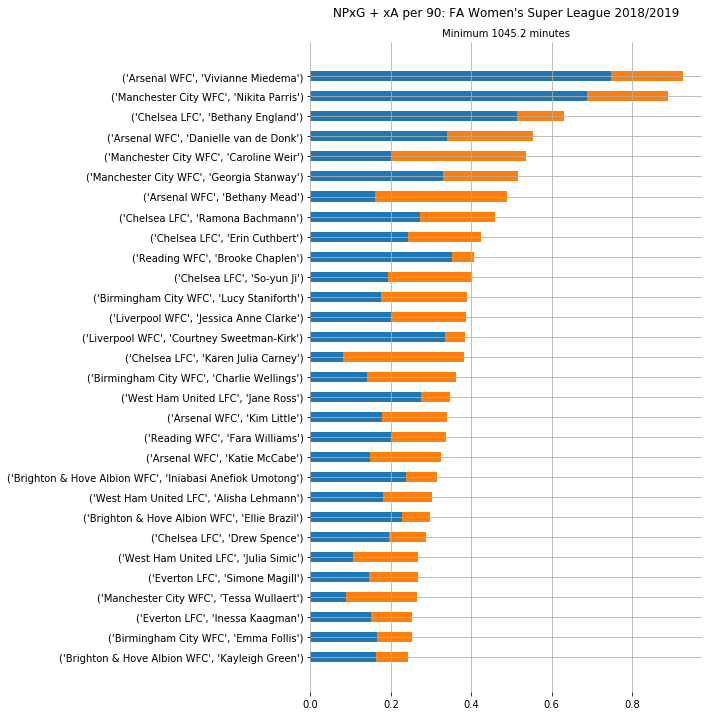

[168.49486112594604, 235.24219751358032, 0.7325918674468994]


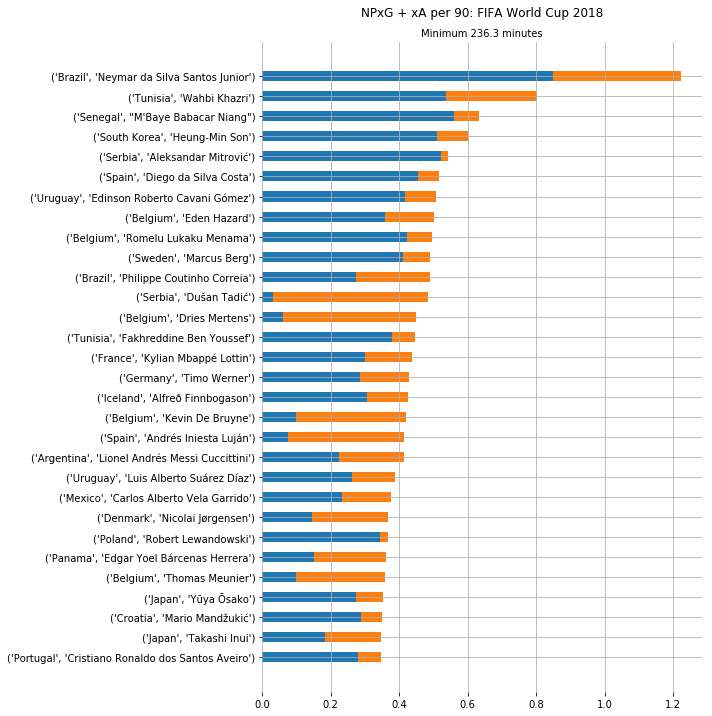

[107.38137912750244, 102.64345860481262, 0.9532737731933594]


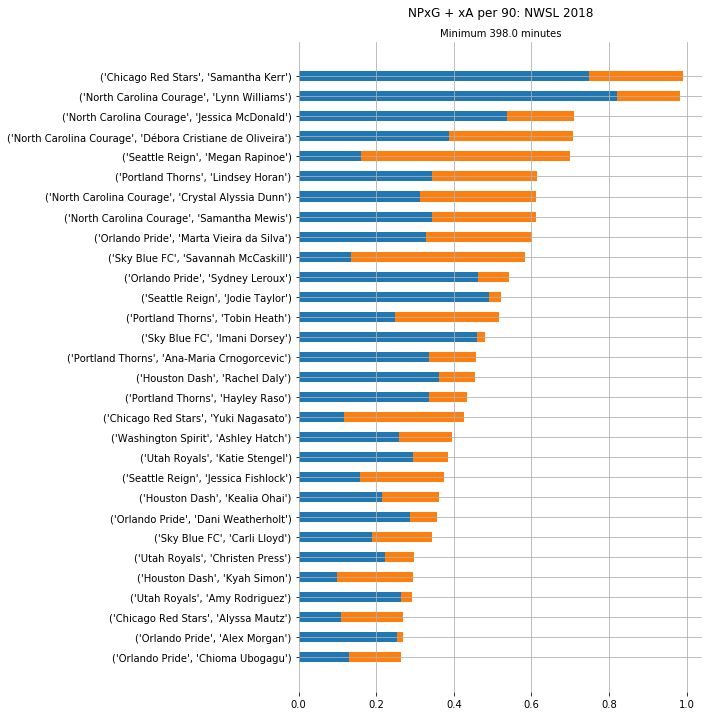

[49.61840510368347, 30.953917741775513, 1.006880521774292]


In [287]:
for com in comps:
    times = []
    fp =  matchesFolder + str(com["competition_id"]) + ".json"
    times.append(time.time())
    d = seasondataframe(fp)
    times.append(time.time())
    on = "player"
    ms = "season"
    
    df = summary1(d, on, ms)
    times.append(time.time())
    if on == "player":
        fig, ax, plt = barxgchart(df, com)
        plt.show()
        times.append(time.time())
        
    else:
        z = grouped_scatter(df, com)
        for i in range(len(z)):
            z[i][2].show()
        for team in df.team.values:
            z = grouped_rolling(team, df)
            for i in range(len(z)):
                z[i][2].show()
    print([times[i] - times[i-1] for i in range(1, len(times))])


In [288]:
on = "team"
ms = "match"

df = summary1(d, on, ms)

In [289]:
dri = df.reset_index()

In [290]:
i = dri.loc[dri.team_name=="Portland Thorns", "match_id"]

In [295]:
for i in range(len(df)/2):
    print(df.index[i+1])
    print(df.index[i])

TypeError: 'float' object cannot be interpreted as an integer